# Model Build
Building and testing models notebook for Google Colab.

The daily temperature from the weather API will be used as our training data.

I have built a class that will allow us to build a recurrent neural network (TF2). One can easily play around with the hyper parameters of through this class, including the type of recurrent layer (GRU or LSTM) and even the number of recurrent layers the model will have.

Two functions are written to search through the possible hyper parameters. From these we can train and select the most optimised model.

Lastly the hundreds of models genereated will be analysed. the best model will be recreated and its predictions plotted against a test set.

Be sure to switch to GPU in the run time


In [10]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#my file path to data on Gdrive
! ls drive/MyDrive/0_neural_net_weather_forecasts_on_cloud/Data

results_table_1621536110.csv  results_table_1621765059.csv   temp_model.h5
results_table_1621583745.csv  results_table_temp.csv	     weather_data.csv
results_table_1621688232.csv  results_table_temp_smooth.csv


In [3]:
os.chdir('drive/MyDrive/0_neural_net_weather_forecasts_on_cloud/Data')

## Load data and split

In [4]:
df = pd.read_csv('weather_data.csv')

#get temp and time
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y')
df = df.set_index('datetime')

temp = df['temp']

#split data (Save a week for testing. Train and Validation made in class)
temp_train = temp.iloc[:-7]
temp_test = temp.iloc[-7:]


##Define the model class

In [12]:
class BuildModel():
    """
    Build a model. Arguments allow one to customise the hyper parameters
    ATTRIBUTES :- 
    length - number of steps in time sequence to feed the rnn
    layers_num - number of rnn layers in model (capped at 3)
    layers_type - select "LSTM" or "GRU"
    units - number of units in rnn layers
    num_step_preds - number of steps/days in time to predict
    dropout - dropout % to be applied to rnn units
    batch_size - number of samples to feed model at a time.
    patience - how many epochs to wait before stopping model after finding good score.
    model_name - file name of model we save. must end in ".h5" eg 'temp_model.h5'
    """
    def __init__(self, model_name, length=10, layers_num=1, layers_type='LSTM',\
                 units=50, num_step_preds=1, dropout=0.0, epochs=8,\
                 batch_size=1, patience=5):
        
        #assertions for input
        assert 0 < layers_num < 4, "1 <= layers_num <= 3"
        assert layers_type in ['LSTM', 'GRU'], "layers_type is LSTM or GRU"
        assert 0 <= dropout < 1, "dropout must be float < 1"
        assert model_name[-3:] == '.h5', "End model_name with '.h5'"
        
        #initialise
        self.length = length
        self.layers_num = layers_num
        self.layers_type = layers_type
        self.units = units
        self.num_step_preds = num_step_preds
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.model_name = model_name
        self.n_features = 1
        
        #callbacks
        self.callbacks =[EarlyStopping(monitor='val_loss', patience=patience),\
                         ModelCheckpoint(self.model_name, monitor='val_loss',\
                                         save_best_only=True)]
        
        #BUILD MODEL
        ##inputs
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=(self.length, self.n_features)))
        
        ##add extra layers as required (or not if layers_num = 1)
        for i in range(layers_num - 1):
            self.model.add(eval('{}(units={}, dropout={}, return_sequences=True)'\
                .format(self.layers_type, self.units, self.dropout)))
                
        ##closing rnn layer (do not return squences)
        self.model.add(eval('{}(units={}, dropout={})'\
                .format(self.layers_type, self.units, self.dropout)))
            
        ##Dense output
        self.model.add(Dense(units=self.num_step_preds))
                       
        #compile model
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    def setupData(self, series, val_days=450):
        """
        splits data, scales data, creates generators for the model
        """
        assert val_days > self.length , "val_days must exceed length"
        
        #split data into train and validation
        self.train = series.iloc[:-val_days]
        self.validation = series.iloc[-val_days:]
        
        #scale data for neural network suitability
        self.scaler = MinMaxScaler()
        self.scaler.fit(self.train.values.reshape(-1,1))
        
        self.train_scaled = \
            self.scaler.transform(self.train.values.reshape(-1,1))
        
        self.validation_scaled = \
             self.scaler.transform(self.validation.values.reshape(-1,1))
        
        #create time series generators
        self.generator = \
             TimeseriesGenerator(data=self.train_scaled,\
                                 targets=self.train_scaled,\
                                 length=self.length,\
                                 batch_size=self.batch_size)
                 
        self.val_generator = \
             TimeseriesGenerator(data=self.validation_scaled,\
                                 targets=self.validation_scaled,\
                                 length=self.length,\
                                 batch_size=self.batch_size)

    def fitModel(self):
        """
        Fits the model on your generators for training and validation sets.
        EarlyStopping call back ends training if val_loss doesnt improve.
        Record epoch metrics in a DataFrame.
        """
        self.model.fit(self.generator, validation_data=self.val_generator,\
                       epochs=self.epochs, callbacks=self.callbacks)
            
        self.history = pd.DataFrame(self.model.history.history)
        
    def loadModel(self):
        """
        Load a model instead of fitting a new one (uses model_name)
        """
        self.model = tf.keras.models.load_model(self.model_name)
            
    def predAhead(self, days, series=None):
        """
        Predicts a number of days ahead set by the user. Input your own
        series or dont if you want to predict off of the validation set.
        """
        assert self.num_step_preds == 1,\
            "sorry, function not yet available for multi step models"
        
        #use end of the validation set to project forward if no series given
        if series == None:
            series = self.validation
        
        #get end of the series to plug into the model
        assert len(series) >= self.length,\
            "series must be at least {} days".format(self.length)
            
        series_cut = series.iloc[-self.length:]
        
        #scale inputs to what model is expecting    
        series_scaled = \
            self.scaler.transform(series_cut.values.reshape(-1,1))
            
        #predict ahead by appending predictions and removing first values
        pred_series = series_scaled.reshape(1, self.length, self.n_features)
        predictions = []
        
        for i in range(days):
            pred = self.model.predict(pred_series)
            pred_series = np.append(pred_series[:,1:,:], [pred], axis=1)
            predictions.append(pred)
            
        #inverse scale back to original units
        predictions = np.array(predictions)
        predictions = self.scaler.inverse_transform(\
                           predictions.reshape(days, self.n_features))\
                          .round(1)
        
        #convert to pandas series
        predictions = pd.Series(predictions.reshape(days))
        predictions.index = self.validation.index[-days:] +\
                                 dt.timedelta(days=days)
            
        return predictions
    
    def plotPreds(self, predictions, test_series=None, run_up=None,\
                  ylabel='units'):
        """
        plot the predictions of the model. plot them against another series
        (test series). plot with with a run up leading to the pred period
        (validation set).
        """
        #set up figure
        plt.figure(figsize=(10,6))
        plt.ylabel(ylabel)
        plt.xlabel('datetime')
        
        #plot lines
        if run_up is None:
            run_up = self.validation[-7:]
            
        if test_series is not None:
            plt.plot(pd.concat([run_up, test_series[:1]]))
            plt.plot(test_series)
            
        else:
            plt.plot(run_up)
            
        #plot points
        plt.scatter(predictions.index, predictions, edgecolors='k',\
                    label='predictions', c='#2ca02c', s=64)
            
        if test_series is not None:
            plt.scatter(test_series.index, test_series, marker='X',\
                        edgecolors='k', label='test_data', c='#ff7f0e', s=200)
                
        plt.legend()


##Define Functions for searching over the model's hyperparameters
NOTE: Requires Pandas 1.2.4

In [ ]:
#! pip install pandas==1.2.4

In [ ]:

def gridTableGen(length: list, layers_num: list, layers_type: list,\
               units: list,  dropout: list):
    """returns table of every combo for the hyperparameters"""
    
    #get cross joins to acquire every combination
    grid_table = pd.DataFrame(length).merge(\
                 pd.DataFrame(layers_num), how='cross').merge(\
                 pd.DataFrame(layers_type), how='cross').merge(\
                 pd.DataFrame(units), how='cross').merge(\
                 pd.DataFrame(dropout), how='cross')
                                                     
    grid_table.columns = \
        ['length', 'layers_num', 'layers_type', 'units', 'dropout']
        
    return grid_table



def gridSearch(grid_table, data):
    """searches through hyperparameters in grid_table to determine optimium model"""
    #record time for file_name
    time_now = str(round(time.time()))
        
    #make results table to append results onto
    results_cols =\
        pd.DataFrame(columns=['loss', 'mae', 'val_loss', 'val_mae', 'epochs'])
        
    results_table = pd.concat([grid_table, results_cols], axis=1)
    
    #iterate through the table and fit the models
    for i, row in grid_table.iterrows():
        #input hyperparameters
        print('\nNow Training ({})\n{}'.format(i, row.to_dict()))
        grid_mod = \
            BuildModel(length=row['length'], layers_num=row['layers_num'],\
                       layers_type=row['layers_type'],units=row['units'],\
                       num_step_preds=1, dropout=row['dropout'], epochs=2,\
                       batch_size=10, patience=5)
        
        #setup data and train the model
        grid_mod.setupData(data)
        grid_mod.fitModel()
        
        #find best epoch (val_mae)
        hist = grid_mod.history
        best_epoch = hist[hist['val_mae'] == hist['val_mae'].min()]\
                     .iloc[:1]
        
        #update results table
        results_table.loc[i, ['loss', 'mae', 'val_loss', 'val_mae']] =\
            best_epoch.values[0].round(4)
        
        results_table.loc[i, 'epochs'] = best_epoch.index[0]
        
        #save to drive
        results_table.to_csv('results_table_' + time_now + '.csv', index=False)
        
    return results_table


##Use functions and class to optimise a model

In [ ]:
#Hyperparameters
length = [1, 5, 10, 30, 90, 180, 365]
layers_num = [1, 2, 3]
layers_type = ['GRU', 'LSTM']
units = [10, 20, 40, 80, 160] 
dropout = [0.0, 0.25, 0.5]

#get every combo
grid_table = gridTableGen(length, layers_num, layers_type, units, dropout)
print('\nN combos: {}'.format(len(grid_table)))

#search
results = gridSearch(grid_table, temp_train)

Streaming output truncated to the last 5000 lines.
Epoch 10/250
186/186 [==============================] - 2s 8ms/step - loss: 0.0041 - mae: 0.0504 - val_loss: 0.0056 - val_mae: 0.0610
Epoch 11/250
186/186 [==============================] - 2s 9ms/step - loss: 0.0038 - mae: 0.0485 - val_loss: 0.0041 - val_mae: 0.0494
Epoch 12/250
186/186 [==============================] - 2s 9ms/step - loss: 0.0037 - mae: 0.0470 - val_loss: 0.0040 - val_mae: 0.0493
Epoch 13/250
186/186 [==============================] - 2s 8ms/step - loss: 0.0038 - mae: 0.0485 - val_loss: 0.0040 - val_mae: 0.0495
Epoch 14/250
186/186 [==============================] - 2s 8ms/step - loss: 0.0040 - mae: 0.0488 - val_loss: 0.0046 - val_mae: 0.0548
Epoch 15/250
186/186 [==============================] - 2s 11ms/step - loss: 0.0039 - mae: 0.0493 - val_loss: 0.0040 - val_mae: 0.0495
Epoch 16/250
186/186 [==============================] - 2s 10ms/step - loss: 0.0041 - mae: 0.0502 - val_loss: 0.0040 - val_mae: 0.0490
Epoch 17/

## Analyse the Grid Search Results

In [8]:
#load it from drive
gs = pd.read_csv('results_table_temp.csv')

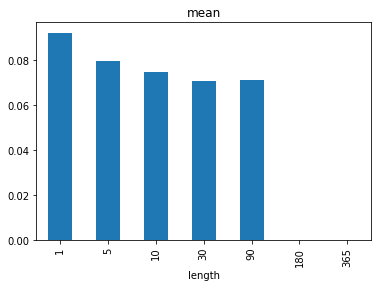

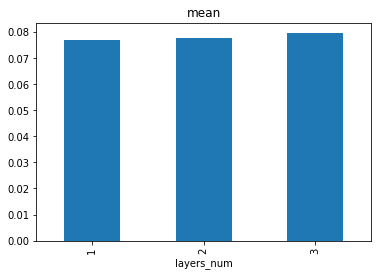

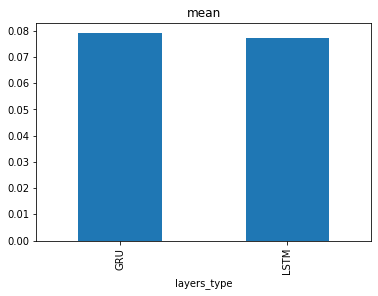

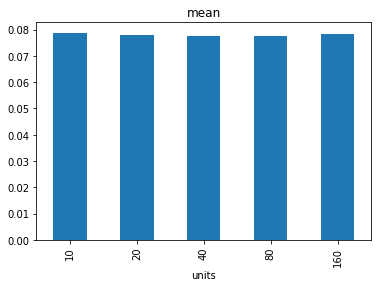

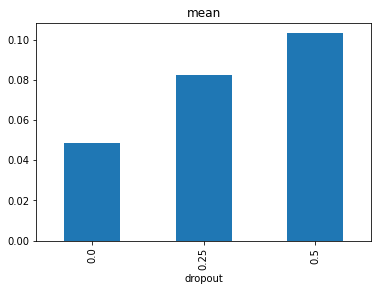

In [11]:
gs.groupby('length')['val_mae'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('layers_num')['val_mae'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('layers_type')['val_mae'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('units')['val_mae'].mean().plot(kind='bar', title='mean'); plt.show()
gs.groupby('dropout')['val_mae'].mean().plot(kind='bar', title='mean'); plt.show()

Whilst the MAE isnt much better than the baseline, the model is picking up a trend.

We see this by its increasing performance as we feed it longer sequences. 


The model is learning to predict the future better by being fed more history at a time.

Dropout does not improve the model performance. Its not often dropout is used in RNN networks, they tend to overfit for other reasons.

LSTM is just slightly better than GRU.
Increasing the number of RNN layers does not improve the predictive power of the model.

## Recreate the best model and compare against test data

In [14]:
best_model_params = gs.sort_values('val_mae').iloc[0]
best_model_params

length             90
layers_num          1
layers_type       GRU
units             160
dropout             0
loss           0.0036
mae            0.0473
val_loss       0.0037
val_mae        0.0471
epochs             95
Name: 372, dtype: object

In [15]:
best_model = BuildModel(model_name='best_temp_model.h5', length=90, layers_num=1,\
                        layers_type='GRU', units=160, dropout=0, epochs=120, batch_size=10,\
                        patience=10)

best_model.setupData(temp_train)
best_model.fitModel()

Epoch 1/120
186/186 [==============================] - 34s 9ms/step - loss: 0.0410 - mae: 0.1313 - val_loss: 0.0074 - val_mae: 0.0672
Epoch 2/120
186/186 [==============================] - 1s 6ms/step - loss: 0.0063 - mae: 0.0630 - val_loss: 0.0059 - val_mae: 0.0598
Epoch 3/120
186/186 [==============================] - 1s 6ms/step - loss: 0.0049 - mae: 0.0562 - val_loss: 0.0052 - val_mae: 0.0561
Epoch 4/120
186/186 [==============================] - 1s 6ms/step - loss: 0.0045 - mae: 0.0533 - val_loss: 0.0054 - val_mae: 0.0571
Epoch 5/120
186/186 [==============================] - 1s 6ms/step - loss: 0.0042 - mae: 0.0516 - val_loss: 0.0049 - val_mae: 0.0563
Epoch 6/120
186/186 [==============================] - 1s 6ms/step - loss: 0.0038 - mae: 0.0485 - val_loss: 0.0053 - val_mae: 0.0590
Epoch 7/120
186/186 [==============================] - 1s 6ms/step - loss: 0.0042 - mae: 0.0507 - val_loss: 0.0041 - val_mae: 0.0508
Epoch 8/120
186/186 [==============================] - 1s 6ms/step -

In [16]:
#load best performer
best_model.loadModel()

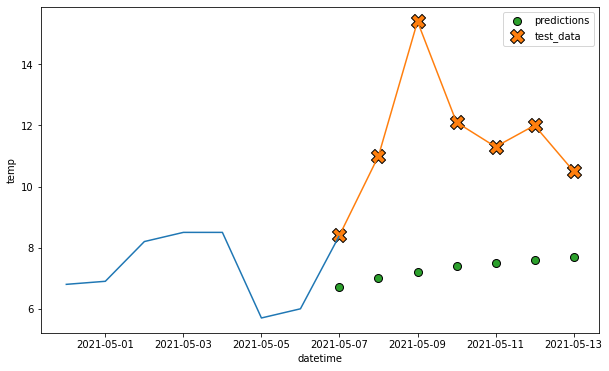

In [17]:
#predict a week
week_pred = best_model.predAhead(7)

#plot against test week
best_model.plotPreds(week_pred, temp_test, ylabel='temp')

Thats really not much better than just predicting the last point in the series like the baseline did. 

There is some variation here since the model did appreciate longer series being fed into it. So it has performed just slightly better than the baseline.

We can do more! I suspect that the series was just too erratic for our model to fit to.

In the next notebook we will add a new hyperparameter to the model. This will smoove the time series that the model is fed. Maybe then, it will be able to lockdown the signal and ignore the noise.